# DENUE analysis my block -test-

This notebook covers the first steps towards an urban land use classifier. In it:
1. The DENUE database is downloaded for a specific area
2. A classification of the DENUE by activity is assigned to each point
3. Each DENUE point gets assigned to an urban block
4. An iterative process produces a Kernel Density Estimation for each activity classification and each block

## Import libraries

In [1]:
import geopandas as gpd
import pandas as pd
import numpy as np
# import odc
import zipfile

from shapely.geometry import Point, Polygon

import seaborn as sns
import matplotlib.pyplot as plt

# from typing import Optional
from spatial_kde import spatial_kernel_density

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

import os
import sys

module_path = os.path.abspath(os.path.join('../../'))
if module_path not in sys.path:
    sys.path.append(module_path)
    import aup
else:
    import aup

## Download and read data

### Area of analysis

In [2]:
aoa_gdf = gpd.read_file("../../data/processed/prediccion_uso_suelo/Distrito_Zona5.geojson")
print(aoa_gdf.shape)
aoa_gdf.head(2)

(1, 4)


,id,area,perimeter,geometry
0,0,3.456908e+07,22034.335455,"POLYGON ((662437.93 2284457.02, 662421.516 228..."


In [3]:
print(aoa_gdf.crs)

EPSG:32613


<Axes: >

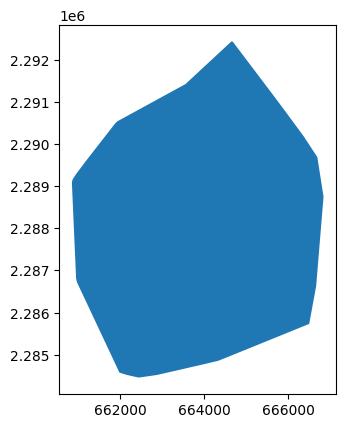

In [4]:
aoa_gdf.plot()

In [5]:
aoa_gdf = aoa_gdf.to_crs("EPSG:4326")

### DENUE

In [6]:
poly_geom = aoa_gdf.dissolve().geometry.iloc[0]
poly_wkt = poly_geom.wkt  # Este sí es un string

In [7]:
print(f"Tipo de geometría: {aoa_gdf.dissolve().geometry.type.iloc[0]}")

Tipo de geometría: Polygon


In [8]:
schema = "denue"
table = "denue_2022"

denue_gdf = aup.gdf_from_polygon(aoa_gdf, schema, table)

denue_gdf = denue_gdf[['cve_ent','cve_mun','cve_loc',
                       'ageb','manzana',
                       'codigo_act','per_ocu','geometry']].copy()

print(denue_gdf.shape)
denue_gdf.head(2)

(7374, 8)


,cve_ent,cve_mun,cve_loc,ageb,manzana,codigo_act,per_ocu,geometry
0,14,120,0001,3293,022,434224,0 a 5 personas,POINT (-103.41014 20.70906)
1,14,120,0001,1155,017,434211,6 a 10 personas,POINT (-103.41017 20.70831)


### Census blocks

In [9]:
schema = "sociodemografico"
table = "censo_inegi_20_mza"

# Consulta que devuelve WKT en lugar de geometría nativa
query_censo = f"""
SELECT 
"cvegeo_mza",
"pobtot","geometry" FROM {schema}.{table}
WHERE ST_Intersects(geometry, \'SRID=4326;{poly_wkt}\')
"""

block_gdf = aup.gdf_from_query(query_censo)

print(block_gdf.shape)
block_gdf.head(2)

(1821, 3)


,cvegeo_mza,pobtot,geometry
0,1412000011225001,0,"POLYGON ((-103.43256 20.67151, -103.43314 20.6..."
1,1412000011225002,103,"POLYGON ((-103.4316 20.67233, -103.43152 20.67..."


## Data treatment and preprocessing

### Change CRS

In [10]:
aoa_gdf = aoa_gdf.to_crs("EPSG:6372")
denue_gdf = denue_gdf.to_crs("EPSG:6372")
block_gdf = block_gdf.to_crs("EPSG:6372")

### DENUE classification by activity

Clasificar las distintas actividades económicas con base en su terminación en "codigo_act" basándonos en el Directorio Estadístico Nacional de Unidades Económicas

In [11]:
# Función para clasificar según la terminación de codigo_act
def asignar_tipo(codigo):
    if pd.isna(codigo):  # Si está vacío
        return 'Sin código'
    
    # Asegurar que sea string para evaluar el código
    codigo_str = str(codigo).strip()

    if not codigo_str.isdigit():
        return 'Código inválido'
    
    # Define tus conjuntos de códigos
    categorias = {
        'agropecuario': ['11'],
        
        'industria': {'31', '32', '33'},
        
        'servicios':{'48', '49','51', '52', '53', '54',
                     '55','56','81'},
    
        'alojamiento': {'72'},
        
        'comercio': {'43', '46'},
        
        'cultural_recreativo': {'71'},
        
        'educacion': {'61'},
        
        'salud': {'62'},
    
        'gobierno': {'93'},
    
        'otros': {'21','22','23'} }

    for k in categorias.keys():
        if codigo_str[:2] in categorias[k]:
            return k

# Aplica la función al DataFrame
denue_gdf['tipo_act'] = denue_gdf['codigo_act'].apply(asignar_tipo)

In [12]:
denue_gdf.head(3)

,cve_ent,cve_mun,cve_loc,ageb,manzana,codigo_act,per_ocu,geometry,tipo_act
0,14,120,0001,3293,022,434224,0 a 5 personas,POINT (2353731.096 967575.267),comercio
1,14,120,0001,1155,017,434211,6 a 10 personas,POINT (2353727.215 967493.035),comercio
2,14,120,0001,3293,001,434111,0 a 5 personas,POINT (2353617.269 967458.293),comercio


In [13]:
denue_gdf["tipo_act"].unique()

array(['comercio', 'servicios', 'salud', 'cultural_recreativo',
       'alojamiento', 'educacion', 'industria', 'otros', 'gobierno'],
      dtype=object)

In [14]:
len(denue_gdf[denue_gdf['tipo_act'].isnull()])

0

### DENUE occupied personel

Contabilizar cuántas personas hay ejerciendo cada actividad económica

In [15]:
def number_of_jobs(per_ocu):
    jobs_dict = {'0 a 5 personas':3,
                '6 a 10 personas':8,
                '11 a 30 personas':20,
                '31 a 50 personas':40,
                '51 a 100 personas':75,
                '101 a 250 personas':175,
                '251 y más personas':325}
    per_ocu_num = jobs_dict[per_ocu]
    return per_ocu_num

In [16]:
denue_gdf['per_ocu_num'] = denue_gdf.per_ocu.apply(lambda per_ocu: number_of_jobs(per_ocu))
denue_gdf.head(2)

,cve_ent,cve_mun,cve_loc,ageb,manzana,codigo_act,per_ocu,geometry,tipo_act,per_ocu_num
0,14,120,0001,3293,022,434224,0 a 5 personas,POINT (2353731.096 967575.267),comercio,3
1,14,120,0001,1155,017,434211,6 a 10 personas,POINT (2353727.215 967493.035),comercio,8


In [17]:
denue_gdf.per_ocu_num.unique()

array([  3,   8, 175,  20,  75, 325,  40])

### DENUE to blocks

Create CVEGEO code for each DENUE

In [18]:
denue_gdf['cvegeo_mza'] = (
    denue_gdf['cve_ent'].astype(str).str[:2] +
    denue_gdf['cve_mun'].astype(str).str[:3] +
    denue_gdf['cve_loc'].astype(str).str[:4] +
    denue_gdf['ageb'].astype(str).str[:4] +
    denue_gdf['manzana'].astype(str).str[:3]
)
print(denue_gdf.shape)
denue_gdf.head(2)

(7374, 11)


,cve_ent,cve_mun,cve_loc,ageb,manzana,codigo_act,per_ocu,geometry,tipo_act,per_ocu_num,cvegeo_mza
0,14,120,0001,3293,022,434224,0 a 5 personas,POINT (2353731.096 967575.267),comercio,3,1412000013293022
1,14,120,0001,1155,017,434211,6 a 10 personas,POINT (2353727.215 967493.035),comercio,8,1412000011155017


In [19]:
denue_gdf.cvegeo_mza.apply(len).min() # checks if every element has a 16 character length

np.int64(16)

Test if every DENUE is assigned to a block

In [20]:
denue_gdf.merge(block_gdf[['cvegeo_mza','pobtot']], on='cvegeo_mza', how='inner').pobtot.isna().sum()

np.int64(0)

### Distance from DENUE to block centroids

In [21]:
# 1. Crear GeoDataFrame de manzanas con centroides únicos
block_cnt = block_gdf.copy()
block_cnt['cnt_geometry'] = block_cnt['geometry'].centroid

In [22]:
# 2. Merge block centroid geometry to DENUE gdf
denue_gdf = pd.merge(
    denue_gdf,
    block_cnt[['cvegeo_mza', 'cnt_geometry']],
    on=['cvegeo_mza'],
    how='inner'
)
print(denue_gdf.shape)
denue_gdf.head(2)

(7374, 12)


,cve_ent,cve_mun,cve_loc,ageb,manzana,codigo_act,per_ocu,geometry,tipo_act,per_ocu_num,cvegeo_mza,cnt_geometry
0,14,120,0001,3293,022,434224,0 a 5 personas,POINT (2353731.096 967575.267),comercio,3,1412000013293022,POINT (2353833.871 967723.236)
1,14,120,0001,1155,017,434211,6 a 10 personas,POINT (2353727.215 967493.035),comercio,8,1412000011155017,POINT (2353905.993 967469.414)


In [23]:
# 3. Calcular la distancia de cada punto al centroide de su manzana
denue_gdf['distancia'] = denue_gdf['geometry'].distance(denue_gdf['cnt_geometry'])

In [24]:
# 4. Calcular d_mean por manzana
denue_to_cnt = denue_gdf.groupby(
    ['cvegeo_mza']
)['distancia'].mean().reset_index(name='d_mean')
print(denue_to_cnt.shape)
denue_to_cnt.head(2)

(801, 2)


,cvegeo_mza,d_mean
0,1403900010562024,102.977364
1,1403900010562025,243.797632


In [25]:
# Add average distance to each block centroid
denue_gdf = denue_gdf.merge(denue_to_cnt, on='cvegeo_mza')
print(denue_gdf.shape)
denue_gdf.head(2)

(7374, 14)


,cve_ent,cve_mun,cve_loc,ageb,manzana,codigo_act,per_ocu,geometry,tipo_act,per_ocu_num,cvegeo_mza,cnt_geometry,distancia,d_mean
0,14,120,0001,3293,022,434224,0 a 5 personas,POINT (2353731.096 967575.267),comercio,3,1412000013293022,POINT (2353833.871 967723.236),180.159634,152.188419
1,14,120,0001,1155,017,434211,6 a 10 personas,POINT (2353727.215 967493.035),comercio,8,1412000011155017,POINT (2353905.993 967469.414),180.331768,244.921558


<Axes: >

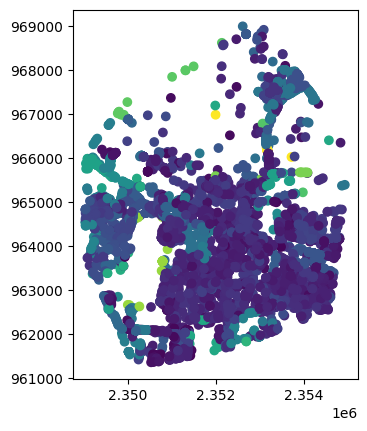

In [26]:
denue_gdf.plot('d_mean')

## Kernel density analysis

#### Single block test

In [27]:
# Obtener el conteo por manzana
conteo_por_manzana = denue_gdf.groupby('cvegeo_mza').size().reset_index(name='conteo')

# Encontrar la manzana con máximo conteo
max_row = conteo_por_manzana.loc[conteo_por_manzana['conteo'].idxmax()]
cvegeo_max = max_row['cvegeo_mza']

In [28]:
block_test = block_gdf.loc[block_gdf.cvegeo_mza==cvegeo_max].copy()

denue_test = denue_gdf.loc[denue_gdf.cvegeo_mza==cvegeo_max].copy()
denue_test = denue_test.reset_index(drop=True)

print(denue_test.shape)
denue_test.head(2)

(256, 14)


,cve_ent,cve_mun,cve_loc,ageb,manzana,codigo_act,per_ocu,geometry,tipo_act,per_ocu_num,cvegeo_mza,cnt_geometry,distancia,d_mean
0,14,120,0001,1189,001,463310,0 a 5 personas,POINT (2354222.499 963838.96),comercio,3,1412000011189001,POINT (2354219.871 963679.044),159.936996,164.543121
1,14,120,0001,1189,001,463310,0 a 5 personas,POINT (2354235.125 963835.98),comercio,3,1412000011189001,POINT (2354219.871 963679.044),157.674657,164.543121


In [29]:
denue_test.per_ocu_num.unique()

array([  3,  75, 175,   8,  20,  40])

In [30]:
# Ejecutar el KDE solo sobre esos puntos
spatial_kernel_density(
    points=denue_test,
    radius = denue_test['d_mean'].mean()/2,
    output_path="../../data/processed/prediccion_uso_suelo/figureskde_manzana_prueba.tif",
    output_pixel_size=5,
    output_driver="GTiff",
    weight_col="per_ocu_num", # Número de personas por ocupación
)

### Iterative analysis

In [40]:
from joblib import Parallel, delayed
from tqdm import tqdm

In [36]:
output_dir = '../../data/processed/prediccion_uso_suelo/test/kde_output/'

**WARNING** Parallel processing

In [37]:
parallel_processing = True

In [41]:

def process_block_activities(idx, block_gdf, denue_gdf, output_dir):
    """Process all activities for a single block"""
    cvegeo_mza = block_gdf.cvegeo_mza
    denue_block = denue_gdf.loc[denue_gdf.cvegeo_mza == cvegeo_mza].copy()
    
    if denue_block.empty:
        return f"Skipped {cvegeo_mza} - no data"
    
    results = []
    for act in denue_block.tipo_act.unique():
        output_file = f"{output_dir}kde_mnz_{cvegeo_mza}_{act}.tif"
        denue_act = denue_block.loc[denue_block.tipo_act==act].copy()
        denue_act = denue_act.reset_index(drop=True)
        
        try:
            spatial_kernel_density(
                points=denue_act,
                radius=(denue_block['d_mean'].mean() / 2),
                output_path=output_file,
                output_pixel_size=1.0,
                output_driver="GTiff",
                weight_col="per_ocu_num",
            )
            results.append(f"Completed {cvegeo_mza}_{act}")
        except Exception as e:
            results.append(f"Failed {cvegeo_mza}_{act}: {str(e)}")
    
    return results

In [42]:
if parallel_processing:
    # Execute in parallel
    
    results = Parallel(n_jobs=16, verbose=1)(
        delayed(process_block_activities)(idx, manzana, denue_gdf, output_dir)
        for idx, manzana in tqdm(block_gdf.iterrows(), desc="Preparing tasks")
    )
    
    print("Processing complete!")

Preparing tasks: 0it [00:00, ?it/s][Parallel(n_jobs=16)]: Using backend LokyBackend with 16 concurrent workers.
Preparing tasks: 48it [00:00, 54.58it/s][Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.9s
Preparing tasks: 192it [00:05, 29.37it/s][Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    5.9s
Preparing tasks: 448it [00:18, 28.16it/s][Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:   18.1s
Preparing tasks: 784it [00:50,  8.62it/s][Parallel(n_jobs=16)]: Done 768 tasks      | elapsed:   51.5s
Preparing tasks: 1248it [01:19, 14.08it/s][Parallel(n_jobs=16)]: Done 1218 tasks      | elapsed:  1.3min
Preparing tasks: 1792it [01:46, 20.10it/s][Parallel(n_jobs=16)]: Done 1768 tasks      | elapsed:  1.8min
Preparing tasks: 1821it [01:48, 16.82it/s]


Processing complete!


[Parallel(n_jobs=16)]: Done 1821 out of 1821 | elapsed:  3.1min finished


In [ ]:
if not parallel_processing:
    for idx, manzana in tqdm(block_gdf.iterrows(), total=len(block_gdf), desc="Processing blocks"):
        
        # Filtrar puntos DENUE dentro de la manzana y con la actividad deseada
        cvegeo_mza = block_gdf.loc[idx].cvegeo_mza
        denue_block = denue_gdf.loc[denue_gdf.cvegeo_mza == cvegeo_mza].copy()
    
        # Saltar si no hay puntos que cumplan ambos criterios
        if denue_block.empty:
            continue
    
        # Nombre de salida con ID y nombre de actividad
        for act in denue_block.tipo_act.unique():
            output_file = f"{output_dir}kde_mnz_{cvegeo_mza}_{act}.tif"
            denue_act = denue_block.loc[denue_block.tipo_act==act].copy()
            denue_act = denue_act.reset_index(drop=True)
    
        
            # Ejecutar el KDE
            spatial_kernel_density(
                points=denue_act,
                radius = (denue_block['d_mean'].mean() / 2),
                output_path=output_file,
                output_pixel_size=1.0,
                output_driver="GTiff",
                weight_col="per_ocu_num",
            )
